In [1]:
# import keras
# from keras.datasets import cifar10
# from keras.models import Model, Sequential
# from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
# from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
# from keras.layers import Concatenate
# from keras.optimizers import Adam
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import Adam, Nadam

import numpy as np
from tqdm import tqdm
from matplotlib import pyplot
from prettytable import PrettyTable
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,LearningRateScheduler,CSVLogger, Callback,ReduceLROnPlateau

import matplotlib.pyplot as plt

from keras import models

Using TensorFlow backend.


In [13]:
from google.colab import drive
drive.mount('gdrive',force_remount=True)

Mounted at gdrive


In [0]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf
# from tensorflow import keras

# from keras import backend as k

# Don't pre-allocate memory; allocate as-needed
# import tensorflow as tf
# tf.config.gpu.set_per_process_memory_fraction(0.75)
# tf.config.gpu.set_per_process_memory_growth(True)
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True

# Create a session with the above options specified.
# k.tensorflow_backend.set_session(tf.Session(config=config))

In [0]:
final_tab = PrettyTable(['Augmentation','l','num_filters','compression','Optimizer','Test Accuracy'])

In [0]:
# Hyperparameters
batch_size = 128
num_classes = 10
epochs = 100
l = 9
num_filter = 24
compression = 1.041
dropout_rate = 0.2


In [6]:
# Load CIFAR10 Data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]

# convert to one hot encoing 
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes) 

170500096/170498071 [==============================] - 6s 0us/step


In [7]:
print('Train Shape:',X_train.shape)
print('Test Shape:',X_test.shape)

Train Shape: (50000, 32, 32, 3)
Test Shape: (10000, 32, 32, 3)


In [0]:
# Dense Block
def denseblock(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_3_3 = layers.Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
            Conv2D_3_3 = layers.Dropout(dropout_rate)(Conv2D_3_3)
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

## transition Blosck
def transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
         Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

#output layer
def output_layer(input):
    global compression
    print('input',input.shape)
    BatchNorm = layers.BatchNormalization()(input)
    print('Batch',BatchNorm.shape)
    relu = layers.Activation('relu')(BatchNorm)
    print('relu',relu.shape)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
    # print('pooling',AvgPooling.shape)
    # flat = layers.Flatten()(AvgPooling)
    # print('flat',flat.shape)
    # # tf.reshape(flat,(4,246))
    # # print(flat.reshape(7,4,4,246,1))
    # output = layers.Conv1D(num_filter,kernel_size=1)(tf.reshape(flat,(1,4,246)))




    conv_layer = layers.Conv2D(10, (1,1), use_bias=False ,padding='same')(AvgPooling)
    last = layers.GlobalMaxPooling2D()(conv_layer)
    output = layers.Activation('softmax')(last)

    return output

In [0]:
num_filter = 12
dropout_rate = 0.2
l = 12

In [9]:

input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = transition(First_Block, num_filter, dropout_rate)

Second_Block = denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = transition(Second_Block, num_filter, dropout_rate)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, num_filter, dropout_rate)

Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
input (?, 4, 4, 240)
Batch (?, 4, 4, 240)
relu (?, 4, 4, 240)


In [0]:
#https://arxiv.org/pdf/1608.06993.pdf
from IPython.display import IFrame, YouTubeVideo
YouTubeVideo(id='-W6y8xnd--U', width=600)

In [10]:
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 24)   648         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 24)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 24)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [0]:
# determine Loss function and Optimizer

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [0]:
model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1, 
                    validation_data=(X_test, y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 112s 2ms/sample - loss: 1.7266 - acc: 0.3533 - val_loss: 1.5696 - val_acc: 0.4313
Epoch 2/10
50000/50000 [==============================] - 96s 2ms/sample - loss: 1.3710 - acc: 0.4956 - val_loss: 1.6232 - val_acc: 0.4712
Epoch 3/10
50000/50000 [==============================] - 96s 2ms/sample - loss: 1.2011 - acc: 0.5626 - val_loss: 1.2632 - val_acc: 0.5566
Epoch 4/10
50000/50000 [==============================] - 96s 2ms/sample - loss: 1.0969 - acc: 0.6025 - val_loss: 1.2591 - val_acc: 0.5634
Epoch 5/10
50000/50000 [==============================] - 95s 2ms/sample - loss: 1.0390 - acc: 0.6257 - val_loss: 1.2728 - val_acc: 0.5842
Epoch 6/10
50000/50000 [==============================] - 96s 2ms/sample - loss: 0.9857 - acc: 0.6452 - val_loss: 1.4487 - val_acc: 0.5634
Epoch 7/10
50000/50000 [==============================] - 96s 2ms/sample - loss: 0.9501 - acc: 0.6597 - val_loss: 1

In [0]:
# Test the model
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 8s 848us/sample - loss: 1.3597 - acc: 0.5937
Test loss: 1.3597363298416139
Test accuracy: 0.5937


In [0]:
# Save the trained weights in to .h5 format
model.save_weights("DNST_model.h5")
print("Saved model to disk")

In [0]:
# ['Augmentation','l','num_filters','compression','Optimizer','Test Accuracy']

final_tab.add_row([None,l, num_filter, compression,'Adam',0.59])


In [0]:
print(final_tab)

+--------------+----+-------------+-------------+-----------+---------------+
| Augmentation | l  | num_filters | compression | Optimizer | Test Accuracy |
+--------------+----+-------------+-------------+-----------+---------------+
|     None     | 12 |      12     |     0.5     |    Adam   |      0.59     |
+--------------+----+-------------+-------------+-----------+---------------+


# DenseNet Function

In [0]:
def dense_net(xtrain,xtest, optim = Adam(),k_size=(3,3), b_size = batch_size, epoch = epochs):
          print('b_size:{} epochs:{}'.format(b_size,epoch))
          input = layers.Input(shape=(img_height, img_width, channel,))
          First_Conv2D = layers.Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

          First_Block = denseblock(First_Conv2D, num_filter, dropout_rate)
          First_Transition = transition(First_Block, num_filter, dropout_rate)

          Second_Block = denseblock(First_Transition, num_filter, dropout_rate)
          Second_Transition = transition(Second_Block, num_filter, dropout_rate)

          Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
          Third_Transition = transition(Third_Block, num_filter, dropout_rate)

          Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
          output = output_layer(Last_Block)


          model = Model(inputs=[input], outputs=[output])
         
          model.compile(loss='categorical_crossentropy',
                        optimizer=Adam(),
                        metrics=['accuracy'])

          model.fit(xtrain, y_train,
                              batch_size=batch_size,
                              epochs=epochs,
                              verbose=1, 
                              validation_data=(xtest, y_test))





          score = model.evaluate(xtest, y_test, verbose=1)
          print('Test loss:', score[0])
          print('Test accuracy:', score[1])

          return model
          


## Image Augmentation Techniques
`Some of the augmentation techniques are as follows`
<ol>
<li>Vertical Shift Augmentation</li>
<li>Horizontal Shift Augmentation</li>
<li>Vertical Flip Augmentation</li>
<li>Horizontal Flip Augmentation</li>
</ol>

## Vertical and Horizontal Shift Augmentation:
`A shift to an image means moving all pixels of the image in one direction, vertically,horizontally while keeping the image dimensions the same.`

In [0]:
# Reff https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/

def vertical_horizontal_shift(arr_imgs):

      # convert to numpy array
      d = arr_imgs.copy()
      
      for i in tqdm(range(d.shape[0]), position=0):
          data = d[i]
          # expand dimension to one sample
          samples = expand_dims(data, 0)
          # create image data augmentation generator
          datagen = ImageDataGenerator(width_shift_range=[-15,15], height_shift_range=[-15,15])
          # prepare iterator
          it = datagen.flow(samples, batch_size=1)
          # generate samples and plot
          # define subplot
          # pyplot.subplot(330 + 1 + i)
          # generate batch of images
          for j in range(9):
              batch = it.next()     
              if j == 0:

                  # convert to unsigned integers for viewing
                  image = batch[0].astype('uint8')
                  d[i] = image
                  # plot raw pixel data
                  break
      return d

### Original Image

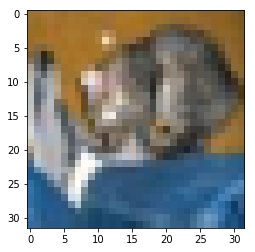

In [0]:
pyplot.imshow(X_test[0])

### After Vertical and Horizontal Shift

100%|██████████| 10000/10000 [00:58<00:00, 169.87it/s]


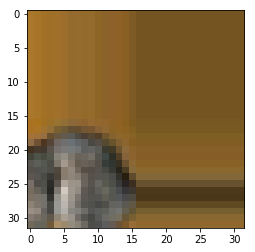

In [0]:
pyplot.imshow(vertical_horizontal_shift(X_test)[0])

## Applying vertical and horizontal shift on vertical and horizontal shift

In [0]:
v_h_shift_train = vertical_horizontal_shift(X_train)
v_h_shift_test  = vertical_horizontal_shift(X_test)


100%|██████████| 10000/10000 [00:08<00:00, 1207.90it/s]


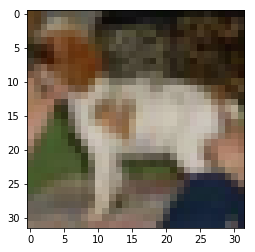

In [0]:
pyplot.imshow(X_test[12])

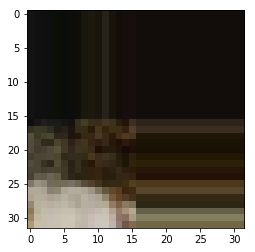

In [0]:
pyplot.imshow(v_h_shift_test[12])

### DenseNet with Adam Optimizer on  Vertical Horizantal Shift Data

In [0]:
v_h_shift_model = dense_net(v_h_shift_train, v_h_shift_test)

b_size:64 epochs:10
Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 191s 4ms/sample - loss: 2.0386 - acc: 0.2355 - val_loss: 1.9912 - val_acc: 0.2963
Epoch 2/10
50000/50000 [==============================] - 174s 3ms/sample - loss: 1.8141 - acc: 0.3226 - val_loss: 1.7621 - val_acc: 0.3535
Epoch 3/10
50000/50000 [==============================] - 174s 3ms/sample - loss: 1.6705 - acc: 0.3824 - val_loss: 1.9284 - val_acc: 0.3487
Epoch 4/10
50000/50000 [==============================] - 174s 3ms/sample - loss: 1.5842 - acc: 0.4157 - val_loss: 1.6201 - val_acc: 0.4319
Epoch 5/10
50000/50000 [==============================] - 174s 3ms/sample - loss: 1.5244 - acc: 0.4409 - val_loss: 1.7455 - val_acc: 0.4045
Epoch 6/10
50000/50000 [==============================] - 174s 3ms/sample - loss: 1.4734 - acc: 0.4619 - val_loss: 1.5040 - val_acc: 0.4666
Epoch 7/10
50000/50000 [==============================] - 174s 3ms/sample - loss: 1.4372 -

In [0]:
final_tab.add_row(['Vertical_Horizantal_Shift',l, num_filter, compression,'Adam',0.42])

### DenseNet with Nadam Optimizer on  Vertical Horizantal Shift Data

In [0]:
v_h_shift_model_nadam = dense_net(v_h_shift_train, v_h_shift_test, optim=Nadam())

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 105s 2ms/sample - loss: 2.1528 - acc: 0.1884 - val_loss: 2.3496 - val_acc: 0.1900
Epoch 2/10
50000/50000 [==============================] - 95s 2ms/sample - loss: 2.0143 - acc: 0.2405 - val_loss: 2.0252 - val_acc: 0.2460
Epoch 3/10
50000/50000 [==============================] - 96s 2ms/sample - loss: 1.8841 - acc: 0.2924 - val_loss: 2.0804 - val_acc: 0.2567
Epoch 4/10
50000/50000 [==============================] - 96s 2ms/sample - loss: 1.7920 - acc: 0.3263 - val_loss: 1.9178 - val_acc: 0.3146
Epoch 5/10
50000/50000 [==============================] - 96s 2ms/sample - loss: 1.7242 - acc: 0.3547 - val_loss: 1.7486 - val_acc: 0.3612
Epoch 6/10
50000/50000 [==============================] - 96s 2ms/sample - loss: 1.6726 - acc: 0.3753 - val_loss: 1.7488 - val_acc: 0.3691
Epoch 7/10
50000/50000 [==============================] - 96s 2ms/sample - loss: 1.6298 - acc: 0.3925 - val_loss: 1

In [0]:
final_tab.add_row(['Vertical_Horizantal_Shift',l, num_filter, compression,'Nadam',0.41])

# Horizontal and Vertical Flip Augmentation

`An image flip means reversing the rows or columns of pixels in the case of a vertical or horizontal flip respectively.`

In [0]:
# Reff https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/


def vertical_horizontal_flip(arr_imgs):

      # convert to numpy array
      d = arr_imgs.copy()
      
      for i in tqdm(range(d.shape[0])):
          data = d[i]
          # expand dimension to one sample
          samples = expand_dims(data, 0)
          # create image data augmentation generator
          datagen = ImageDataGenerator(vertical_flip=True, horizontal_flip=True)
          # prepare iterator
          it = datagen.flow(samples, batch_size=1)
          # generate samples and plot
          # define subplot
          # pyplot.subplot(330 + 1 + i)
          # generate batch of images
          for j in range(9):
            batch = it.next()
            if j == 2:
              # convert to unsigned integers for viewing
              image = batch[0].astype('uint8')
              d[i] = image
              break
            # plot raw pixel data
      return d

### DenseNet with Optimizer on  Vertical Horizantal Flip Data

In [0]:
v_h_flip_xtrain = vertical_horizontal_flip(X_train)
v_h_flip_xtest  = vertical_horizontal_flip(X_test)

100%|██████████| 10000/10000 [00:05<00:00, 1898.82it/s]


#### Before Flipping

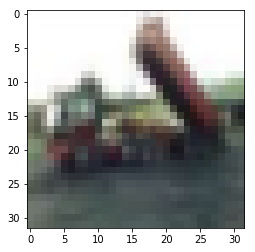

In [0]:
pyplot.imshow(X_train[2])

#### After Flipping

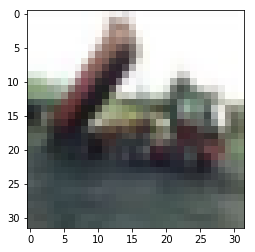

In [0]:
pyplot.imshow(v_h_flip_xtrain[2])

In [0]:
v_h_flip_model = dense_net(v_h_flip_xtrain, v_h_flip_xtest)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 107s 2ms/sample - loss: 1.7911 - acc: 0.3097 - val_loss: 1.6606 - val_acc: 0.3809
Epoch 2/10
50000/50000 [==============================] - 96s 2ms/sample - loss: 1.5231 - acc: 0.4242 - val_loss: 1.6694 - val_acc: 0.4135
Epoch 3/10
50000/50000 [==============================] - 96s 2ms/sample - loss: 1.3828 - acc: 0.4865 - val_loss: 1.4306 - val_acc: 0.4768
Epoch 4/10
50000/50000 [==============================] - 96s 2ms/sample - loss: 1.2782 - acc: 0.5326 - val_loss: 1.4148 - val_acc: 0.5241
Epoch 5/10
50000/50000 [==============================] - 96s 2ms/sample - loss: 1.1989 - acc: 0.5606 - val_loss: 1.3927 - val_acc: 0.5238
Epoch 6/10
50000/50000 [==============================] - 96s 2ms/sample - loss: 1.1467 - acc: 0.5804 - val_loss: 1.4058 - val_acc: 0.5260
Epoch 7/10
50000/50000 [==============================] - 96s 2ms/sample - loss: 1.1055 - acc: 0.5982 - val_loss: 1

In [0]:
final_tab.add_row(['Vertical_Horizantal_Flip',l, num_filter, compression,'Adam',0.55])


### DenseNet with Nadam Optimizer on  Vertical Horizantal Flip Data

In [0]:
v_h_flip_model_nadam = dense_net(v_h_flip_xtrain, v_h_flip_xtest, optim = Nadam())

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 108s 2ms/sample - loss: 1.8078 - acc: 0.3088 - val_loss: 1.7010 - val_acc: 0.3601
Epoch 2/10
50000/50000 [==============================] - 96s 2ms/sample - loss: 1.5287 - acc: 0.4237 - val_loss: 1.4924 - val_acc: 0.4579
Epoch 3/10
50000/50000 [==============================] - 96s 2ms/sample - loss: 1.4101 - acc: 0.4767 - val_loss: 1.5825 - val_acc: 0.4363
Epoch 4/10
50000/50000 [==============================] - 96s 2ms/sample - loss: 1.3354 - acc: 0.5046 - val_loss: 1.4079 - val_acc: 0.4948
Epoch 5/10
50000/50000 [==============================] - 96s 2ms/sample - loss: 1.2751 - acc: 0.5342 - val_loss: 1.5963 - val_acc: 0.4315
Epoch 6/10
50000/50000 [==============================] - 96s 2ms/sample - loss: 1.2214 - acc: 0.5540 - val_loss: 1.3639 - val_acc: 0.5135
Epoch 7/10
50000/50000 [==============================] - 96s 2ms/sample - loss: 1.1718 - acc: 0.5729 - val_loss: 1

In [0]:
final_tab.add_row(['Vertical_Horizantal_Flip',l, num_filter, compression,'Nadam',0.59])

## Brightness Augmentation
`The brightness of the image can be augmented by either randomly darkening images, brightening images, or both.`


In [0]:
def brightness(arr_imgs):

      # convert to numpy array
      d = arr_imgs.copy()
      
      for i in tqdm(range(d.shape[0])):
          data = d[i]
          # expand dimension to one sample
          samples = expand_dims(data, 0)
          # create image data augmentation generator
          datagen = ImageDataGenerator(brightness_range=[0.5,0.6])
          # prepare iterator
          it = datagen.flow(samples, batch_size=1)
          # generate samples and plot
          # define subplot
          # pyplot.subplot(330 + 1 + i)
          # generate batch of images
          for j in range(9):
            batch = it.next()
            if j == 8:
              # convert to unsigned integers for viewing
              image = batch[0].astype('uint8')
              d[i] = image
              break
            # plot raw pixel data
      return d

In [0]:
bright_xtrain = brightness(X_train)
bright_xtest = brightness(X_test)

100%|██████████| 10000/10000 [00:30<00:00, 328.29it/s]


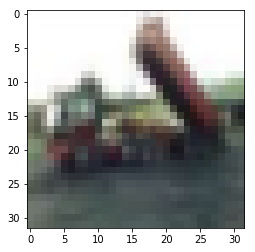

In [0]:
pyplot.imshow(X_train[2])

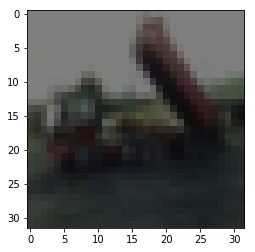

In [0]:
pyplot.imshow(bright_xtrain[2])

### DenseNet with Adam Optimizer on Brightness Augmentation Data

In [0]:
bright_model = dense_net(bright_xtrain, bright_xtest)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 110s 2ms/sample - loss: 1.7495 - acc: 0.3368 - val_loss: 2.0044 - val_acc: 0.3110
Epoch 2/10
50000/50000 [==============================] - 97s 2ms/sample - loss: 1.3959 - acc: 0.4854 - val_loss: 1.5577 - val_acc: 0.4708
Epoch 3/10
50000/50000 [==============================] - 97s 2ms/sample - loss: 1.2084 - acc: 0.5608 - val_loss: 1.2202 - val_acc: 0.5645
Epoch 4/10
50000/50000 [==============================] - 96s 2ms/sample - loss: 1.0993 - acc: 0.6017 - val_loss: 1.3322 - val_acc: 0.5412
Epoch 5/10
50000/50000 [==============================] - 96s 2ms/sample - loss: 1.0283 - acc: 0.6269 - val_loss: 1.1301 - val_acc: 0.6099
Epoch 6/10
50000/50000 [==============================] - 97s 2ms/sample - loss: 0.9844 - acc: 0.6458 - val_loss: 1.2942 - val_acc: 0.5640
Epoch 7/10
50000/50000 [==============================] - 96s 2ms/sample - loss: 0.9409 - acc: 0.6628 - val_loss: 1

In [0]:
final_tab.add_row(['Brightness',l, num_filter, compression,'Adam',0.67])

### DenseNet with Nadam Optimizer on Brightness Augmentation Data

In [0]:
bright_model_nadam = dense_net(bright_xtrain, bright_xtest, optim=Nadam())

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 112s 2ms/sample - loss: 1.7422 - acc: 0.3393 - val_loss: 1.6212 - val_acc: 0.4032
Epoch 2/10
50000/50000 [==============================] - 97s 2ms/sample - loss: 1.3962 - acc: 0.4847 - val_loss: 1.5139 - val_acc: 0.4873
Epoch 3/10
50000/50000 [==============================] - 97s 2ms/sample - loss: 1.2154 - acc: 0.5559 - val_loss: 1.1808 - val_acc: 0.5713
Epoch 4/10
50000/50000 [==============================] - 96s 2ms/sample - loss: 1.1144 - acc: 0.5982 - val_loss: 1.2420 - val_acc: 0.5821
Epoch 5/10
50000/50000 [==============================] - 96s 2ms/sample - loss: 1.0450 - acc: 0.6246 - val_loss: 1.0905 - val_acc: 0.6186
Epoch 6/10
50000/50000 [==============================] - 96s 2ms/sample - loss: 0.9883 - acc: 0.6453 - val_loss: 1.2437 - val_acc: 0.5991
Epoch 7/10
50000/50000 [==============================] - 96s 2ms/sample - loss: 0.9478 - acc: 0.6600 - val_loss: 1

In [0]:
final_tab.add_row(['Brightness',l, num_filter, compression,'Nadam',0.67])

## Feature Standardization


In [0]:
def standard(arr_imgs):

      # convert to numpy array
      d = arr_imgs.copy()
      
      for i in tqdm(range(d.shape[0])):
          data = d[i]
          # expand dimension to one sample
          samples = expand_dims(data, 0)
          # create image data augmentation generator
          datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
          # prepare iterator
          it = datagen.flow(samples, batch_size=1)
          # generate samples and plot
          # define subplot
          # pyplot.subplot(330 + 1 + i)
          # generate batch of images
          for j in range(9):
              batch = it.next()
              if j == 5:
                # convert to unsigned integers for viewing
                image = batch[0].astype('uint8')
                d[i] = image
                break
                # plot raw pixel data
      return d

In [0]:
# stand_xtrain = standard(X_train)
stand_xtest  = standard(X_test)

  0%|          | 0/10000 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
100%|██████████| 10000/10000 [00:08<00:00, 1211.73it/s]


### DenseNet with Adam Optimizer on Standardized Data

In [0]:
stand_model = dense_net(stand_xtrain, stand_xtest)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 116s 2ms/sample - loss: 1.7418 - acc: 0.3469 - val_loss: 1.5594 - val_acc: 0.4418
Epoch 2/10
50000/50000 [==============================] - 98s 2ms/sample - loss: 1.3799 - acc: 0.4947 - val_loss: 1.6403 - val_acc: 0.4437
Epoch 3/10
50000/50000 [==============================] - 98s 2ms/sample - loss: 1.2129 - acc: 0.5580 - val_loss: 1.1566 - val_acc: 0.5843
Epoch 4/10
50000/50000 [==============================] - 97s 2ms/sample - loss: 1.1102 - acc: 0.6008 - val_loss: 1.2747 - val_acc: 0.5612
Epoch 5/10
50000/50000 [==============================] - 97s 2ms/sample - loss: 1.0414 - acc: 0.6250 - val_loss: 1.2837 - val_acc: 0.5759
Epoch 6/10
50000/50000 [==============================] - 97s 2ms/sample - loss: 0.9909 - acc: 0.6446 - val_loss: 1.2212 - val_acc: 0.5953
Epoch 7/10
50000/50000 [==============================] - 98s 2ms/sample - loss: 0.9481 - acc: 0.6585 - val_loss: 1

In [0]:
final_tab.add_row(['Standardized',l, num_filter, compression,'Adam',0.63])

## DenseNet with Nadam Optimizer on Standardized Data

In [0]:
stand_model_nadam = dense_net(stand_xtrain,stand_xtest, optim = Nadam())

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 117s 2ms/sample - loss: 1.7193 - acc: 0.3541 - val_loss: 2.2187 - val_acc: 0.3326
Epoch 2/10
50000/50000 [==============================] - 98s 2ms/sample - loss: 1.3688 - acc: 0.4973 - val_loss: 1.5857 - val_acc: 0.4589
Epoch 3/10
50000/50000 [==============================] - 98s 2ms/sample - loss: 1.2211 - acc: 0.5536 - val_loss: 1.5198 - val_acc: 0.5076
Epoch 4/10
50000/50000 [==============================] - 98s 2ms/sample - loss: 1.1158 - acc: 0.5921 - val_loss: 1.4742 - val_acc: 0.5246
Epoch 5/10
50000/50000 [==============================] - 98s 2ms/sample - loss: 1.0399 - acc: 0.6241 - val_loss: 1.0491 - val_acc: 0.6400
Epoch 6/10
50000/50000 [==============================] - 98s 2ms/sample - loss: 0.9917 - acc: 0.6427 - val_loss: 1.0171 - val_acc: 0.6433
Epoch 7/10
50000/50000 [==============================] - 98s 2ms/sample - loss: 0.9490 - acc: 0.6574 - val_loss: 1

In [0]:
final_tab.add_row(['Standardized',l, num_filter, compression,'Nadam',0.63])

<strong>Now lets try with changing some of the parameters</strong>

In [0]:
l = 8
num_filter = 38
compression = 1

## DenseNet with Adam Optimizer on Vertical Horizantal Shift

In [0]:
v_h_shift_model2 = dense_net(v_h_shift_train,v_h_shift_test)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 295s 6ms/sample - loss: 1.9932 - acc: 0.2628 - val_loss: 2.8806 - val_acc: 0.2111
Epoch 2/10
50000/50000 [==============================] - 269s 5ms/sample - loss: 1.6862 - acc: 0.3815 - val_loss: 1.8009 - val_acc: 0.3622
Epoch 3/10
50000/50000 [==============================] - 269s 5ms/sample - loss: 1.5389 - acc: 0.4382 - val_loss: 1.7920 - val_acc: 0.4283
Epoch 4/10
50000/50000 [==============================] - 269s 5ms/sample - loss: 1.4265 - acc: 0.4839 - val_loss: 1.6365 - val_acc: 0.4426
Epoch 5/10
50000/50000 [==============================] - 269s 5ms/sample - loss: 1.3483 - acc: 0.5146 - val_loss: 1.5748 - val_acc: 0.4719
Epoch 6/10
50000/50000 [==============================] - 270s 5ms/sample - loss: 1.2871 - acc: 0.5360 - val_loss: 1.4691 - val_acc: 0.4993
Epoch 7/10
50000/50000 [==============================] - 270s 5ms/sample - loss: 1.2317 - acc: 0.5591 - val_l

In [0]:
final_tab.add_row(['Vertical_Horizantal_shift',l, num_filter, compression,'Adam',0.52])

## DenseNet with Nadam Optimizer on Vertical Horizantal Shift

In [0]:
v_h_shift_model2_nadam = dense_net(v_h_shift_train,v_h_shift_test,optim=Nadam())

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 288s 6ms/sample - loss: 1.9957 - acc: 0.2672 - val_loss: 2.0370 - val_acc: 0.2677
Epoch 2/10
50000/50000 [==============================] - 270s 5ms/sample - loss: 1.6974 - acc: 0.3788 - val_loss: 5.1156 - val_acc: 0.1736
Epoch 3/10
50000/50000 [==============================] - 270s 5ms/sample - loss: 1.5542 - acc: 0.4349 - val_loss: 1.7738 - val_acc: 0.3912
Epoch 4/10
50000/50000 [==============================] - 270s 5ms/sample - loss: 1.4505 - acc: 0.4729 - val_loss: 2.0385 - val_acc: 0.3929
Epoch 5/10
50000/50000 [==============================] - 270s 5ms/sample - loss: 1.3684 - acc: 0.5075 - val_loss: 1.6887 - val_acc: 0.4409
Epoch 6/10
50000/50000 [==============================] - 270s 5ms/sample - loss: 1.3042 - acc: 0.5300 - val_loss: 1.4545 - val_acc: 0.5053
Epoch 7/10
50000/50000 [==============================] - 270s 5ms/sample - loss: 1.2509 - acc: 0.5508 - val_l

In [0]:
final_tab.add_row(['Vertical_Horizantal_shift',l, num_filter, compression,'Nadam',0.53])

## DenseNet with Adam Optimizer on Vertical Horizantal Flip

In [0]:
v_h_flip_model2 = dense_net(v_h_flip_xtrain,v_h_flip_xtest)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 292s 6ms/sample - loss: 1.5497 - acc: 0.4271 - val_loss: 2.2234 - val_acc: 0.3542
Epoch 2/10
50000/50000 [==============================] - 271s 5ms/sample - loss: 1.1109 - acc: 0.6005 - val_loss: 1.9077 - val_acc: 0.4839
Epoch 3/10
50000/50000 [==============================] - 271s 5ms/sample - loss: 0.9230 - acc: 0.6673 - val_loss: 1.4761 - val_acc: 0.5829
Epoch 4/10
50000/50000 [==============================] - 271s 5ms/sample - loss: 0.8136 - acc: 0.7084 - val_loss: 1.4341 - val_acc: 0.5631
Epoch 5/10
50000/50000 [==============================] - 271s 5ms/sample - loss: 0.7315 - acc: 0.7382 - val_loss: 1.2017 - val_acc: 0.6418
Epoch 6/10
50000/50000 [==============================] - 271s 5ms/sample - loss: 0.6601 - acc: 0.7642 - val_loss: 1.3863 - val_acc: 0.6156
Epoch 7/10
50000/50000 [==============================] - 271s 5ms/sample - loss: 0.6100 - acc: 0.7844 - val_l

In [0]:
final_tab.add_row(['Vertical_Horizantal_flip',l, num_filter, compression,'Adam',0.72])

## DenseNet with Nadam Optimizer on Vertical Horizantal Flip

In [0]:
v_h_flip_model2_nadam = dense_net(v_h_flip_xtrain,v_h_flip_xtest,optim=Nadam())

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 293s 6ms/sample - loss: 1.5328 - acc: 0.4368 - val_loss: 1.8540 - val_acc: 0.3984
Epoch 2/10
50000/50000 [==============================] - 272s 5ms/sample - loss: 1.0911 - acc: 0.6057 - val_loss: 1.1753 - val_acc: 0.6160
Epoch 3/10
50000/50000 [==============================] - 272s 5ms/sample - loss: 0.9227 - acc: 0.6685 - val_loss: 1.1697 - val_acc: 0.6228
Epoch 4/10
50000/50000 [==============================] - 272s 5ms/sample - loss: 0.8073 - acc: 0.7112 - val_loss: 2.4143 - val_acc: 0.4619
Epoch 5/10
50000/50000 [==============================] - 272s 5ms/sample - loss: 0.7319 - acc: 0.7377 - val_loss: 1.4257 - val_acc: 0.6086
Epoch 6/10
50000/50000 [==============================] - 272s 5ms/sample - loss: 0.6665 - acc: 0.7597 - val_loss: 1.1833 - val_acc: 0.6594
Epoch 7/10
50000/50000 [==============================] - 272s 5ms/sample - loss: 0.6127 - acc: 0.7821 - val_l

In [0]:
final_tab.add_row(['Vertical_Horizantal_flip',l, num_filter, compression,'Nadam',0.67])

## DenseNet with Adam Optimizer on Brightness

In [0]:
bright_model2 = dense_net(bright_xtrain, bright_xtest)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 262s 5ms/sample - loss: 1.3957 - acc: 0.4889 - val_loss: 2.1067 - val_acc: 0.4403
Epoch 2/10
50000/50000 [==============================] - 247s 5ms/sample - loss: 0.8968 - acc: 0.6821 - val_loss: 1.0364 - val_acc: 0.6581
Epoch 3/10
50000/50000 [==============================] - 246s 5ms/sample - loss: 0.7104 - acc: 0.7495 - val_loss: 0.9763 - val_acc: 0.6957
Epoch 4/10
50000/50000 [==============================] - 246s 5ms/sample - loss: 0.6112 - acc: 0.7871 - val_loss: 1.1059 - val_acc: 0.6766
Epoch 5/10
50000/50000 [==============================] - 247s 5ms/sample - loss: 0.5337 - acc: 0.8115 - val_loss: 1.3122 - val_acc: 0.6740
Epoch 6/10
50000/50000 [==============================] - 247s 5ms/sample - loss: 0.4847 - acc: 0.8298 - val_loss: 1.0951 - val_acc: 0.7134
Epoch 7/10
50000/50000 [==============================] - 247s 5ms/sample - loss: 0.4338 - acc: 0.8492 - val_l

In [0]:
final_tab.add_row(['Brightness',l, num_filter, compression,'Adam',0.79])

## DenseNet with Nadam Optimizer on Brightness

In [0]:
bright_model2_nadam = dense_net(bright_xtrain, bright_xtest, optim=Nadam())

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 252s 5ms/sample - loss: 1.3535 - acc: 0.5083 - val_loss: 2.6686 - val_acc: 0.3786
Epoch 2/10
50000/50000 [==============================] - 247s 5ms/sample - loss: 0.8746 - acc: 0.6905 - val_loss: 1.4745 - val_acc: 0.5859
Epoch 3/10
50000/50000 [==============================] - 247s 5ms/sample - loss: 0.7027 - acc: 0.7521 - val_loss: 1.2347 - val_acc: 0.6524
Epoch 4/10
50000/50000 [==============================] - 247s 5ms/sample - loss: 0.6028 - acc: 0.7891 - val_loss: 0.9355 - val_acc: 0.7102
Epoch 5/10
50000/50000 [==============================] - 247s 5ms/sample - loss: 0.5348 - acc: 0.8140 - val_loss: 0.7049 - val_acc: 0.7758
Epoch 6/10
50000/50000 [==============================] - 246s 5ms/sample - loss: 0.4797 - acc: 0.8329 - val_loss: 0.8034 - val_acc: 0.7683
Epoch 7/10
50000/50000 [==============================] - 246s 5ms/sample - loss: 0.4343 - acc: 0.8484 - val_l

In [0]:
final_tab.add_row(['Brightness',l, num_filter, compression,'Nadam',0.70])

## DenseNet with Adam Optimizer on Standardized Data

In [0]:
stand_model2 = dense_net(stand_xtrain,stand_xtest)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 290s 6ms/sample - loss: 1.3630 - acc: 0.5059 - val_loss: 1.8054 - val_acc: 0.4663
Epoch 2/10
50000/50000 [==============================] - 271s 5ms/sample - loss: 0.8947 - acc: 0.6818 - val_loss: 2.0782 - val_acc: 0.5325
Epoch 3/10
50000/50000 [==============================] - 272s 5ms/sample - loss: 0.7168 - acc: 0.7482 - val_loss: 1.2432 - val_acc: 0.6331
Epoch 4/10
50000/50000 [==============================] - 271s 5ms/sample - loss: 0.6117 - acc: 0.7844 - val_loss: 1.6101 - val_acc: 0.6382
Epoch 5/10
50000/50000 [==============================] - 271s 5ms/sample - loss: 0.5369 - acc: 0.8114 - val_loss: 1.1828 - val_acc: 0.6678
Epoch 6/10
50000/50000 [==============================] - 271s 5ms/sample - loss: 0.4824 - acc: 0.8326 - val_loss: 0.9018 - val_acc: 0.7418
Epoch 7/10
50000/50000 [==============================] - 271s 5ms/sample - loss: 0.4367 - acc: 0.8485 - val_l

In [0]:
final_tab.add_row(['Standardized',l, num_filter, compression,'Adam',0.77])

## DenseNet with Nadam Optimizer on Standardized Data

In [0]:
stand_model2_nadam = dense_net(stand_xtrain,stand_xtest, optim = Nadam())

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 291s 6ms/sample - loss: 1.3426 - acc: 0.5116 - val_loss: 1.8898 - val_acc: 0.4669
Epoch 2/10
50000/50000 [==============================] - 272s 5ms/sample - loss: 0.8734 - acc: 0.6906 - val_loss: 2.5935 - val_acc: 0.4521
Epoch 3/10
50000/50000 [==============================] - 272s 5ms/sample - loss: 0.7015 - acc: 0.7531 - val_loss: 1.2029 - val_acc: 0.6608
Epoch 4/10
50000/50000 [==============================] - 273s 5ms/sample - loss: 0.5990 - acc: 0.7908 - val_loss: 1.4715 - val_acc: 0.6416
Epoch 5/10
50000/50000 [==============================] - 273s 5ms/sample - loss: 0.5287 - acc: 0.8131 - val_loss: 0.6723 - val_acc: 0.7890
Epoch 6/10
50000/50000 [==============================] - 273s 5ms/sample - loss: 0.4771 - acc: 0.8332 - val_loss: 2.1752 - val_acc: 0.5709
Epoch 7/10
50000/50000 [==============================] - 272s 5ms/sample - loss: 0.4321 - acc: 0.8491 - val_l

In [0]:
final_tab.add_row(['Standardized',l, num_filter, compression,'Nadam',0.80])

In [0]:
print(final_tab)

+---------------------------+----+-------------+-------------+-----------+---------------+
|        Augmentation       | l  | num_filters | compression | Optimizer | Test Accuracy |
+---------------------------+----+-------------+-------------+-----------+---------------+
|            None           | 12 |      12     |     0.5     |    Adam   |      0.59     |
| Vertical_Horizantal_Shift | 12 |      12     |     0.5     |    Adam   |      0.41     |
| Vertical_Horizantal_Shift | 12 |      12     |     0.5     |   Nadam   |     0.409     |
|  Vertical_Horizantal_Flip | 12 |      12     |     0.5     |    Adam   |     0.604     |
|  Vertical_Horizantal_Flip | 12 |      12     |     0.5     |   Nadam   |      0.61     |
|         Brightness        | 12 |      12     |     0.5     |    Adam   |      0.66     |
|         Brightness        | 12 |      12     |     0.5     |   Nadam   |      0.67     |
|        Standardized       | 12 |      12     |     0.5     |    Adam   |      0.63     |

### Observations:

<strong>If we observe the test accuracy when l =8, no_filters = 38, compression = 1 is higher so we shall use these changed parameters</strong>

<strong>We shall add the image augmentation which influenced the test accuracy lot i.e brightness,standardization, flipping</strong>

In [11]:
%%time

datagen = ImageDataGenerator(
    
    brightness_range=[0.5,1.9],
    featurewise_center=True, featurewise_std_normalization=True,
    width_shift_range = 0.125,
    horizontal_flip=True,vertical_flip=True,rotation_range=15,
    fill_mode='nearest'
)

CPU times: user 178 µs, sys: 35 µs, total: 213 µs
Wall time: 218 µs


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


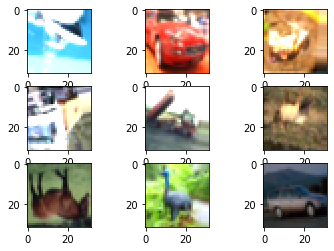

In [0]:

for X_batch, y_batch in datagen.flow(X_train[:9], y_train[:9], batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        
        plt.imshow(X_batch[i].astype('uint8'), cmap=plt.get_cmap('prism'))
    plt.show()
    break

In [0]:
l

In [0]:
def dense_net2(xtrain,xtest, optim = Adam(),k_size=(3,3), b_size = batch_size, epoch = epochs):
          print('b_size:{} epochs:{} '.format(b_size,epoch))
          input = layers.Input(shape=(img_height, img_width, channel,))
          First_Conv2D = layers.Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

          First_Block = denseblock(First_Conv2D, num_filter, dropout_rate)
          First_Transition = transition(First_Block, num_filter, dropout_rate)

          Second_Block = denseblock(First_Transition, num_filter, dropout_rate)
          Second_Transition = transition(Second_Block, num_filter, dropout_rate)

          Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
          Third_Transition = transition(Third_Block, num_filter, dropout_rate)

          Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
          output = output_layer(Last_Block)
        

          model = Model(inputs=[input], outputs=[output])

          reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 5, min_lr = 0.000001)

          # early_stop = EarlyStopping(monitor = "val_loss", patience = 10)

          def decay_fn(epoch, lr):
              if epoch < 50:
                  return 0.001
              elif epoch >= 50 and epoch < 75:
                  return 0.0001
              else:
                  return 0.00001

          lr_scheduler = LearningRateScheduler(decay_fn)

          csv_logger = CSVLogger('training.log')




          checkpoint = ModelCheckpoint('gdrive/My Drive/cnnoncifar/models/model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5',
                                       verbose=1, monitor='val_acc',save_best_only=True, mode='auto')  

         


          model.compile(loss='categorical_crossentropy',
                        optimizer=Adam(),
                        metrics=['accuracy'])

          # model.fit(xtrain, y_train,
          #                     batch_size=batch_size,
          #                     epochs=epochs,
          #                     verbose=1, 
          #                     validation_data=(xtest, y_test))
          print(model.summary())
          model.fit_generator(
            datagen.flow(xtrain, y_train, batch_size=b_size),
            steps_per_epoch=(len(xtrain)/batch_size)*5,              
            epochs=epoch,
            verbose = 1,
            validation_data=(xtest, y_test),callbacks=[checkpoint])



          score = model.evaluate(xtest, y_test, verbose=1)
          print('Test loss:', score[0])
          print('Test accuracy:', score[1])

          return model
          


In [0]:
# l = 8
# num_filter = 27
compression = 1.041
# 
# 


# no of layers in dense block
l = 9 
# growth rate k
num_filter = 24


In [0]:
model = dense_net2(X_train,X_test,epoch=150)

b_size:128 epochs:150 
input (?, 4, 4, 240)
Batch (?, 4, 4, 240)
relu (?, 4, 4, 240)
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_82 (Conv2D)              (None, 32, 32, 24)   648         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_80 (BatchNo (None, 32, 32, 24)   96          conv2d_82[0][0]                  
__________________________________________________________________________________________________
activation_82 (Activation)      (None, 32, 32, 24)   0           batch_normalization_80[0][0]     
_______

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/150


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_dat

10000/1953 [=========================================================================================================================================================] - 11s 1ms/sample - loss: 2.4117 - acc: 0.4869

Epoch 00001: val_acc improved from -inf to 0.48690, saving model to gdrive/My Drive/cnnoncifar/models/model-001-0.514679-0.486900.h5
1954/1953 [==============================] - 948s 485ms/step - loss: 1.3261 - acc: 0.5147 - val_loss: 2.1875 - val_acc: 0.4869
Epoch 2/150
10000/1953 [=========================================================================================================================================================] - 9s 873us/sample - loss: 1.3751 - acc: 0.6039

Epoch 00002: val_acc improved from 0.48690 to 0.60390, saving model to gdrive/My Drive/cnnoncifar/models/model-002-0.670043-0.603900.h5
1954/1953 [==============================] - 897s 459ms/step - loss: 0.9237 - acc: 0.6700 - val_loss: 1.4341 - val_acc: 0.6039
Epoch 3/150
10000/1953 [============

<strong> At epoch 33 the accuracy was 87% but because of time restrictions by google colab fitting the model is stoped any how since model is already saved at 33rd epoch we shall continue to fit from that epoch</strong>


In [0]:
# reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 5, min_lr = 0.000001)

# early_stop = EarlyStopping(monitor = "val_loss", patience = 10)

def decay_fn(epoch, lr):
    if epoch < 50:
        return 0.001
    elif epoch >= 50 and epoch < 75:
        return 0.0001
    else:
        return 0.00001

lr_scheduler = LearningRateScheduler(decay_fn)

csv_logger = CSVLogger('training.log')





checkpoint = ModelCheckpoint('gdrive/My Drive/cnnoncifar/models/model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5',
                                       verbose=1, monitor='val_acc',save_best_only=True, mode='auto')  

         
model.load_weights('gdrive/My Drive/cnnoncifar/models/model-033-0.893153-0.879100.h5')


model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

# model.fit(xtrain, y_train,
#                     batch_size=batch_size,
#                     epochs=epochs,
#                     verbose=1, 
#                     validation_data=(xtest, y_test))
print(model.summary())
model.fit_generator(
    datagen.flow(X_train, y_train, batch_size=batch_size), 
    steps_per_epoch=(len(X_train)/batch_size)*5,
              
    epochs=150, verbose = 1,initial_epoch = 32, 
    validation_data=(X_test, y_test),
    callbacks=[checkpoint])






10000/1953 [=========================================================================================================================================================] - 8s 848us/sample - loss: 0.3856 - acc: 0.8887

Epoch 00061: val_acc did not improve from 0.90130
1954/1953 [==============================] - 886s 454ms/step - loss: 0.2363 - acc: 0.9161 - val_loss: 0.4000 - val_acc: 0.8887
Epoch 62/150
1699/1953 [=========================>....] - ETA: 1:53 - loss: 0.2356 - acc: 0.9166Buffered data was truncated after reaching the output size limit.

<strong> At epoch 60 the accuracy was 90% but because of time restrictions by google colab fitting the model is stoped any how since model is already saved at 60rd epoch we shall continue to fit from that epoch</strong>

In [0]:
# reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 5, min_lr = 0.000001)

# early_stop = EarlyStopping(monitor = "val_loss", patience = 10)

def decay_fn(epoch, lr):
    if epoch < 50:
        return 0.001
    elif epoch >= 50 and epoch < 75:
        return 0.0001
    else:
        return 0.00001

lr_scheduler = LearningRateScheduler(decay_fn)

csv_logger = CSVLogger('training.log')





checkpoint = ModelCheckpoint('gdrive/My Drive/cnnoncifar/models/model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5',
                                       verbose=1, monitor='val_acc',save_best_only=True, mode='auto')  

         
model.load_weights('gdrive/My Drive/cnnoncifar/models/model-060-0.915397-0.901300.h5')


model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

# model.fit(xtrain, y_train,
#                     batch_size=batch_size,
#                     epochs=epochs,
#                     verbose=1, 
#                     validation_data=(xtest, y_test))
print(model.summary())
model.fit_generator(
    datagen.flow(X_train, y_train, batch_size=batch_size), 
    steps_per_epoch=(len(X_train)/batch_size)*5,
              
    epochs=150, verbose = 1,initial_epoch = 61, 
    validation_data=(X_test, y_test),
    callbacks=[checkpoint])






Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_165 (Conv2D)             (None, 32, 32, 24)   648         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_164 (BatchN (None, 32, 32, 24)   96          conv2d_165[0][0]                 
__________________________________________________________________________________________________
activation_165 (Activation)     (None, 32, 32, 24)   0           batch_normalization_164[0][0]    
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 62/150


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_dat

10000/1953 [=========================================================================================================================================================] - 12s 1ms/sample - loss: 0.2617 - acc: 0.9017

Epoch 00062: val_acc improved from -inf to 0.90170, saving model to gdrive/My Drive/cnnoncifar/models/model-062-0.916165-0.901700.h5
1954/1953 [==============================] - 963s 493ms/step - loss: 0.2368 - acc: 0.9162 - val_loss: 0.3534 - val_acc: 0.9017
Epoch 63/150
10000/1953 [=========================================================================================================================================================] - 9s 867us/sample - loss: 0.3246 - acc: 0.8949

Epoch 00063: val_acc did not improve from 0.90170
1954/1953 [==============================] - 891s 456ms/step - loss: 0.2354 - acc: 0.9156 - val_loss: 0.3893 - val_acc: 0.8949
Epoch 64/150
10000/1953 [================================================================================================

In [15]:
model.load_weights('gdrive/My Drive/cnnoncifar/models/model-071-0.920683-0.902400.h5')
model.compile(loss='categorical_crossentropy',
                        optimizer=Adam(),
                        metrics=['accuracy'])

# model.fit(X_train,y_train)

train_acc = model.evaluate(X_train,y_train)
val_acc   = model.evaluate(X_test,y_test)


10000/10000 [==============================] - 11s 1ms/sample - loss: 0.3466 - acc: 0.9024


In [16]:
print(train_acc[1],val_acc[1])

0.96122 0.9024


In [19]:
print('The train accuracy is     : {}%'.format(96))
print('The test accuracy is      : {} i.e ~{}%'.format(90.24,91))
print('Number of parameters used : {}'.format(model.count_params()))

The train accuracy is     : 96%
The test accuracy is      : 90.24 i.e ~91%
Number of parameters used : 974568
